# 1. Loading Data

In [1]:
import sys
import gc
import os
import warnings
import pickle
import statsmodels.api as sm
from pylab import rcParams
import time
from  datetime import datetime, timedelta

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, metrics

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

register_matplotlib_converters()
sns.set()

/usr/local/anaconda3/envs/data_science/lib/python3.8/site-packages/lightgbm/__init__.py:42: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  warnings.warn("Starting from version 2.2.1, the library file in distribution wheels for macOS "


## 1.1 Functions

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def display_missing(df):    
    for col in df.columns.tolist():  
        if df[col].isnull().sum() != 0:
            print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    


## 1.2 Loading data grid

In [3]:
DATA_GRID_INPUT_DIR = '.'

In [4]:
print('Loading the data...')

data = pd.read_pickle(f'{DATA_GRID_INPUT_DIR}/m5_data_model2.pkl')

Loading the data...


## 1.3 Init variables

In [5]:
h = 28 # Prediction horizon
max_lags = 65 # Max lags used
TRAINING_LAST_DAY_NUM = 1913 # Last day for training data
FIRST_PRED_DAY = datetime(2016,4, 25) # First prediction day
FIRST_LOADING_DAY = datetime(2013, 4,7) # First day for training
FIRST_LOADING_DAY_NUM = 800
SEED = 7


## 1.4 Cuting the dataset

In [6]:
# Determine first needed day for training
# data = data.loc[data['date'] >= FIRST_LOADING_DAY] # So we will have space for lag and rolling features
# gc.collect()
# data.shape

## 1.5 Computing weights (simulating WMRSSE cost function)

We set weights for training samples, based on competition's weighting methodology. It is hard to simulate it fully, 
but we try to select more valuable items, based on sales for last 28 days in train period. We use agregated sales for 
each state and department and then compute weights based on these values.

In [7]:
# Selecting last 28 days for calculations
# last_28d = data.loc[data.date>='2016-03-28', ['id', 'item_id', 'state_id', 'dept_id', 'sales', 'date']].copy()


In [8]:
# First convert 'sales' column to float32, 
# so the sum() number will fit into its range
# last_28d['sales'] = last_28d['sales'].astype(np.float32)
# total_by_state_dept = last_28d.groupby(['state_id', 'dept_id'])['sales'].sum().reset_index(name='total_by_state_dept')
# total_by_id = last_28d.groupby(['item_id', 'state_id', 'dept_id'])['sales'].sum().reset_index(name='total_by_id')
# last_28d = pd.merge(last_28d, total_by_state_dept, on=['state_id', 'dept_id'], copy = False)
# last_28d = pd.merge(last_28d, total_by_id, on=['item_id', 'state_id', 'dept_id'], copy = False)
# last_28d['weights'] = last_28d['total_by_id'] / last_28d['total_by_state_dept']

# del total_by_state_dept, total_by_id
# gc.collect()

In [9]:
# Scale weights to have more effect from value in training
# last_28d['weights'] *= 20

# # Because CA items have more weight overall, 
# # we also multiply them by 1.6 (based on weights from GitHub)
# # TODO: If it will work, compute these values in pandas
# last_28d.loc[last_28d['state_id'] == 0, 'weights'] *= 1.6

# # Adding weights to 1, so they better fit to LGBM weights
# last_28d['weights'] = 1 + last_28d['weights']

In [10]:
# last_28d.loc[last_28d['state_id'] == 1, 'weights'].hist()

In [11]:
# last_28d.loc[last_28d['state_id'] == 0, 'sales'].sum()

In [12]:
# last_28d.loc[last_28d['weights']>2, 'weights'].count()/28

In [13]:
# # Add weights to main data grid
# data.set_index('id', inplace=True)
# data = data.join(last_28d[['id', 'weights']].set_index('id')).reset_index()

# del last_28d
# gc.collect()

In [14]:
data

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1,12.0,2011-01-29,11101,2,1,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961
1,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_2,15.0,2011-01-30,11101,3,2,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961
2,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_3,0.0,2011-01-31,11101,1,3,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_4,0.0,2011-02-01,11101,5,4,2,2011,0,0,0,0,1.0,1.0,0.0,0.459961
4,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_5,0.0,2011-02-02,11101,6,5,2,2011,0,0,0,0,1.0,0.0,1.0,0.459961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46027952,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.980469
46027953,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1912,1.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.280273
46027954,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1913,3.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.280273
46027955,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1912,0.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.000000


# 2. Feature Engineering

## Creating features


In [15]:
def create_features(df):
    lags = [7, 28]
    lag_cols = [f"lag_t{lag}" for lag in lags ]

    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df[["id","sales"]].groupby("id")["sales"].shift(lag).astype(np.float16)

    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            df[f"rmean_{lag}_{win}"] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean()).astype(np.float16)
               
    # Adding lagged and rolling features
#     df_grpby_id_sales = df[["id","sales"]].groupby(["id"])["sales"]
#     for val in [1, 2, 3, 4, 5, 6, 7, 28]:
#         df[f"lag_t{val}"] = df_grpby_id_sales.shift(val).astype(np.float16)

#     SHIFT_DAYS = 1 # So we make this features starting from previous day
#     for val in [7, 14, 28]:
#         df[f"rolling_mean_t{val}"] = df_grpby_id_sales.transform(lambda x: x.shift(SHIFT_DAYS).rolling(val).mean()).astype(np.float16)
#         df[f"rolling_std_t{val}"] = df_grpby_id_sales.transform(lambda x: x.shift(SHIFT_DAYS).rolling(val).std()).astype(np.float16)        
#         df[f"rolling_max_t{val}"] = df_grpby_id_sales.transform(lambda x: x.shift(SHIFT_DAYS).rolling(val).max()).astype(np.float16)

    # Adding price related features
#     PRICE_WINDOW = 60
#     df_grpby_id_sell_price = df[['id','sell_price']].groupby(["id"])["sell_price"]
#     df['price_max_t60'] = df_grpby_id_sell_price.transform(lambda x: x.rolling(PRICE_WINDOW).max()).astype(np.float16)
#     df['price_min_t60'] = df_grpby_id_sell_price.transform(lambda x: x.rolling(PRICE_WINDOW).min()).astype(np.float16)
#     df['price_std_t60'] = df_grpby_id_sell_price.transform(lambda x: x.rolling(PRICE_WINDOW).std()).astype(np.float16)
#     df['price_mean_t60'] = df_grpby_id_sell_price.transform(lambda x: x.rolling(PRICE_WINDOW).mean()).astype(np.float16)

#     df['price_momentum_t60'] = (df['sell_price'] / df['price_mean_t60']).astype(np.float16)
    df['price_mean_t60'] = df[['id','sell_price']].groupby(["id"])["sell_price"].transform(lambda x: x.rolling(60).mean()).astype(np.float16)
    df['price_momentum_t60'] = (df['sell_price'] / df['price_mean_t60']).astype(np.float16)
    
    date_features = {
        
        "wday": "weekday",
        "woy": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     df.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in df.columns:
            df[date_feat_name] = df[date_feat_name].astype("int16")
        else:
            df[date_feat_name] = getattr(df["date"].dt, date_feat_func).astype("int16")
    

In [16]:
%%time

create_features(data)

CPU times: user 2min 41s, sys: 7.14 s, total: 2min 49s
Wall time: 2min 51s


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 0 to 46027956
Data columns (total 33 columns):
 #   Column              Dtype         
---  ------              -----         
 0   id                  object        
 1   item_id             int16         
 2   dept_id             int8          
 3   store_id            int8          
 4   cat_id              int8          
 5   state_id            int8          
 6   d                   object        
 7   sales               float16       
 8   date                datetime64[ns]
 9   wm_yr_wk            int16         
 10  weekday             int8          
 11  wday                int16         
 12  month               int16         
 13  year                int16         
 14  event_name_1        int8          
 15  event_type_1        int8          
 16  event_name_2        int8          
 17  event_type_2        int8          
 18  snap_CA             float16       
 19  snap_TX             float16       
 20  

In [18]:
data.dropna(inplace = True)
data.shape

(44229047, 33)

In [19]:
data

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_t7,lag_t28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,price_mean_t60,price_momentum_t60,woy,quarter,mday
713989,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_60,0.0,2011-03-29,11109,5,4,3,2011,0,0,0,0,0.0,0.0,0.0,0.419922,0.0,0.0,0.000000,1.142578,0.928711,3.572266,0.433838,0.967773,13,1,29
713990,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_61,0.0,2011-03-30,11109,6,5,3,2011,0,0,0,0,0.0,0.0,0.0,0.419922,0.0,0.0,0.000000,0.285645,0.714355,3.572266,0.433350,0.969238,13,1,30
713991,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_62,0.0,2011-03-31,11109,4,6,3,2011,0,0,0,0,0.0,0.0,0.0,0.419922,0.0,0.0,0.000000,0.000000,0.643066,3.427734,0.432617,0.970703,13,1,31
713992,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_63,0.0,2011-04-01,11109,0,7,4,2011,0,0,0,0,1.0,1.0,0.0,0.419922,0.0,0.0,0.000000,0.000000,0.643066,3.214844,0.431885,0.972168,13,2,1
713996,HOBBIES_1_009_CA_1_validation,8,0,0,0,0,d_60,2.0,2011-03-29,11109,5,4,3,2011,0,0,0,0,0.0,0.0,0.0,1.769531,9.0,0.0,2.000000,1.571289,2.250000,2.035156,1.597656,1.107422,13,1,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46027952,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.980469,0.0,1.0,1.000000,0.714355,0.928711,1.250000,3.980469,1.000000,16,2,24
46027953,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1912,1.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.280273,0.0,2.0,0.856934,1.142578,1.036133,1.107422,1.280273,1.000000,16,2,23
46027954,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1913,3.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.280273,1.0,4.0,0.714355,1.571289,1.036133,1.250000,1.280273,1.000000,16,2,24
46027955,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1912,0.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,2.285156,1.821289,1.786133,1.000000,1.000000,16,2,23


## Reduce mem usage of created features

In [20]:
data = reduce_mem_usage(data)

Mem. usage decreased to 3290.05 Mb (6.0% reduction)


In [21]:
gc.collect()

80

# 3. Fit & Predict

In [22]:
print('Data usage: {} GB'.format(data.memory_usage().sum() / 10**9))
data.head()

Data usage: 3.449865666 GB


,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_t7,lag_t28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,price_mean_t60,price_momentum_t60,woy,quarter,mday
713989,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_60,0.0,2011-03-29,11109,5,4,3,2011,0,0,0,0,0.0,0.0,0.0,0.419922,0.0,0.0,0.0,1.142578,0.928711,3.572266,0.433838,0.967773,13,1,29
713990,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_61,0.0,2011-03-30,11109,6,5,3,2011,0,0,0,0,0.0,0.0,0.0,0.419922,0.0,0.0,0.0,0.285645,0.714355,3.572266,0.433350,0.969238,13,1,30
713991,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_62,0.0,2011-03-31,11109,4,6,3,2011,0,0,0,0,0.0,0.0,0.0,0.419922,0.0,0.0,0.0,0.000000,0.643066,3.427734,0.432617,0.970703,13,1,31
713992,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_63,0.0,2011-04-01,11109,0,7,4,2011,0,0,0,0,1.0,1.0,0.0,0.419922,0.0,0.0,0.0,0.000000,0.643066,3.214844,0.431885,0.972168,13,2,1
713996,HOBBIES_1_009_CA_1_validation,8,0,0,0,0,d_60,2.0,2011-03-29,11109,5,4,3,2011,0,0,0,0,0.0,0.0,0.0,1.769531,9.0,0.0,2.0,1.571289,2.250000,2.035156,1.597656,1.107422,13,1,29


In [23]:
# train_end_dt = datetime(2016, 3, 27)
# valid_end_dt = datetime(2016, 4, 24)

valid_start = datetime(2016, 3, 28)
train_valid_end_dt = datetime(2016, 4, 27)

In [24]:
%%time

cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday", "weights"]
train_cols = data.columns[~data.columns.isin(useless_cols)]
# used_cols = train_cols.append(pd.Index(['weights'])) # with weights

# Splitting train and validation by date (28 days before prediction horizon)
# To drop na values only from training set
# train = data.loc[data.date <= train_end_dt].dropna()
X_train = data[train_cols]
y_train = data["sales"]

X_valid= data.loc[(data.date >= valid_start) & (data.date <= train_valid_end_dt), train_cols]
y_valid = data.loc[(data.date >= valid_start) & (data.date <= train_valid_end_dt), "sales"]
train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=cat_feats, free_raw_data=False)
valid_data = lgb.Dataset(X_valid, label = y_valid, categorical_feature=cat_feats, free_raw_data=False)


# Random train-validation split
# X_train = data[used_cols]
# y_train = data["sales"]

# np.random.seed(SEED)
# valid_inds = np.random.choice(X_train.index.values, 2_000_000, replace = False)
# train_inds = np.setdiff1d(X_train.index.values, valid_inds)

# train_data = lgb.Dataset(X_train.loc[train_inds, train_cols] ,\
#                          label = y_train.loc[train_inds], weight=X_train.loc[train_inds, "weights"],\
#                          categorical_feature=cat_feats, free_raw_data=False)
# valid_data = lgb.Dataset(X_train.loc[valid_inds, train_cols], \
#                          label = y_train.loc[valid_inds], weight=X_train.loc[valid_inds, "weights"],\
#                          categorical_feature=cat_feats, free_raw_data=False)
# del valid_inds, train_inds

del data, X_train, y_train 

gc.collect()


CPU times: user 1.63 s, sys: 976 ms, total: 2.61 s
Wall time: 2.62 s


60

In [25]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'rmse',
            'subsample': 0.5,
            'subsample_freq': 1,
            'learning_rate': 0.03,
            'num_leaves': 2**11-1,
            'min_data_in_leaf': 2**12-1,
            'feature_fraction': 0.5,
            'max_bin': 100,
            'n_estimators': 1400,
            'boost_from_average': False,
            'verbose': 1,
            'seed': SEED,
} 

# params = {
#         "objective" : "poisson",
#         "metric" :"rmse",
#         "force_row_wise" : True,
#         "learning_rate" : 0.075,
# #         "sub_feature" : 0.8,
#         "sub_row" : 0.8,
#         "bagging_freq" : 1,
#         'feature_fraction': 0.8,
#         "lambda_l2" : 0.1,
# #         "nthread" : 4
#         'verbosity': 1,
#         'num_iterations' : 1200,
#         'num_leaves': 2**7-1,
#         "min_data_in_leaf": 2**7-1,
#         'early_stopping_rounds': 125,
#         'seed': SEED,
# }

In [26]:
%%time

m_lgb = lgb.train(params, train_data, valid_sets = [train_data, valid_data], 
                  verbose_eval=50)


[50]	training's rmse: 2.74537	valid_1's rmse: 2.18839
[100]	training's rmse: 2.5034	valid_1's rmse: 2.00541
[150]	training's rmse: 2.45463	valid_1's rmse: 1.98439
[200]	training's rmse: 2.42015	valid_1's rmse: 1.97205
[250]	training's rmse: 2.39797	valid_1's rmse: 1.96305
[300]	training's rmse: 2.38194	valid_1's rmse: 1.95643
[350]	training's rmse: 2.3689	valid_1's rmse: 1.95133
[400]	training's rmse: 2.35729	valid_1's rmse: 1.94639
[450]	training's rmse: 2.34727	valid_1's rmse: 1.94204
[500]	training's rmse: 2.33968	valid_1's rmse: 1.93893
[550]	training's rmse: 2.33066	valid_1's rmse: 1.93484
[600]	training's rmse: 2.32273	valid_1's rmse: 1.93143
[650]	training's rmse: 2.31578	valid_1's rmse: 1.92794
[700]	training's rmse: 2.30822	valid_1's rmse: 1.9245
[750]	training's rmse: 2.30174	valid_1's rmse: 1.92116
[800]	training's rmse: 2.2953	valid_1's rmse: 1.91845
[850]	training's rmse: 2.29024	valid_1's rmse: 1.91612
[900]	training's rmse: 2.28445	valid_1's rmse: 1.91258
[950]	training'

In [27]:
os.system('say "Training complete"')

0

In [28]:
m_lgb.save_model("model.lgb")
#m_lgb = lgb.Booster(model_file='model.lgb')

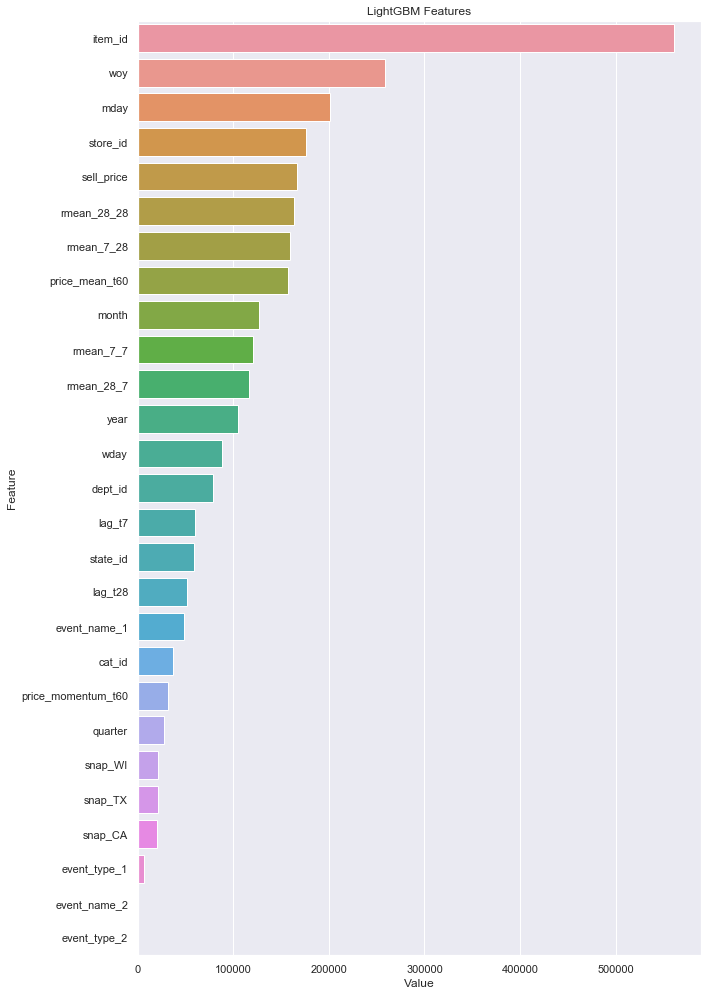

In [29]:
feature_importance = pd.DataFrame({"Value": m_lgb.feature_importance(), "Feature": m_lgb.feature_name()}) \
                    .sort_values(by="Value", ascending=False)

# Change size of the plot, so we can see all features
fig_dims = (10, 14)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(x="Value", y="Feature", ax=ax, data=feature_importance)
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [30]:
# Detection of features with zero-importance
zero_features = list(feature_importance[feature_importance['Value'] == 0]['Feature'])
print('\nThere are {} features with 0.0 importance'.format(len(zero_features)))
print(zero_features)
feature_importance


There are 0 features with 0.0 importance
[]


,Value,Feature
0,561537,item_id
24,258508,woy
26,200792,mday
2,176440,store_id
15,166513,sell_price
21,164009,rmean_28_28
20,159733,rmean_7_28
22,156738,price_mean_t60
6,126828,month
18,120564,rmean_7_7


In [31]:
%%time 

tdata = pd.read_pickle(f'{DATA_GRID_INPUT_DIR}/m5_data_test_model2.pkl')

CPU times: user 146 ms, sys: 118 ms, total: 264 ms
Wall time: 345 ms


In [32]:
def create_lag_features_for_test(df, day):
    # create lag feaures just for single day (faster)
    lags = [7, 28]
    lag_cols = [f"lag_t{lag}" for lag in lags]
    for lag, lag_col in zip(lags, lag_cols):
        df.loc[df.date == day, lag_col] = df.loc[df.date ==day-timedelta(days=lag), 'sales'].values  # !!! main

    windows = [7, 28]
    for window in windows:
        for lag in lags:
            df_window = df[(df.date <= day-timedelta(days=lag)) & (df.date > day-timedelta(days=lag+window))]
            df_window_grouped = df_window.groupby("id").agg({'sales':'mean'}).reindex(df.loc[df.date==day,'id'])
            df.loc[df.date == day,f"rmean_{lag}_{window}"] = df_window_grouped.sales.values     
    
    
## Creating features for test data
def create_date_features_for_test(df):
    # copy of the code from `create_df()` above
    date_features = {
        "wday": "weekday",
        "woy": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
    }

    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in df.columns:
            df[date_feat_name] = df[date_feat_name].astype("int16")
        else:
            df[date_feat_name] = getattr(
                df["date"].dt, date_feat_func).astype("int16")
            
    # Create price features
    df['price_mean_t60'] = df[['id','sell_price']].groupby(["id"])["sell_price"].transform(lambda x: x.rolling(60).mean()).astype(np.float16)
    df['price_momentum_t60'] = (df['sell_price'] / df['price_mean_t60']).astype(np.float16)


In [33]:
create_date_features_for_test(tdata)

In [34]:
%%time

for i in range(0, 28):
    day = FIRST_PRED_DAY + timedelta(days=i)
    print(i, day)
    tst = tdata[(tdata.date >= day - timedelta(days=max_lags)) & (tdata.date <= day)].copy()
    create_lag_features_for_test(tst, day)
    tst = tst.loc[tst.date == day, train_cols]
    tdata.loc[tdata.date == day, "sales"] = 1.03*m_lgb.predict(tst) 


0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00
9 2016-05-04 00:00:00
10 2016-05-05 00:00:00
11 2016-05-06 00:00:00
12 2016-05-07 00:00:00
13 2016-05-08 00:00:00
14 2016-05-09 00:00:00
15 2016-05-10 00:00:00
16 2016-05-11 00:00:00
17 2016-05-12 00:00:00
18 2016-05-13 00:00:00
19 2016-05-14 00:00:00
20 2016-05-15 00:00:00
21 2016-05-16 00:00:00
22 2016-05-17 00:00:00
23 2016-05-18 00:00:00
24 2016-05-19 00:00:00
25 2016-05-20 00:00:00
26 2016-05-21 00:00:00
27 2016-05-22 00:00:00
CPU times: user 1h 2min 34s, sys: 8.1 s, total: 1h 2min 42s
Wall time: 16min 34s


In [35]:
os.system('say "Prediction complete"')

0

In [36]:
tdata.loc[(tdata.date >= FIRST_PRED_DAY) & (tdata.sales > 2)].count()

id                    144148
item_id               144148
dept_id               144148
store_id              144148
cat_id                144148
state_id              144148
d                     144148
sales                 144148
date                  144148
wm_yr_wk              144148
weekday               144148
wday                  144148
month                 144148
year                  144148
event_name_1          144148
event_type_1          144148
event_name_2          144148
event_type_2          144148
snap_CA               144148
snap_TX               144148
snap_WI               144148
sell_price            144148
woy                   144148
quarter               144148
mday                  144148
price_mean_t60        144148
price_momentum_t60    144148
dtype: int64

In [37]:
%%time

tdata_sub = tdata.loc[tdata.date >= FIRST_PRED_DAY, ["id", "sales"]].copy()
tdata_sub.loc[tdata.date >= FIRST_PRED_DAY+ timedelta(days=h), "id"] = tdata_sub.loc[tdata.date >= FIRST_PRED_DAY+timedelta(days=h), 
                                                                     "id"].str.replace("validation$", "evaluation")
tdata_sub["F"] = [f"F{rank}" for rank in tdata_sub.groupby("id")["id"].cumcount()+1]
tdata_sub = tdata_sub.set_index(["id", "F" ]).unstack()["sales"][[f"F{i}" for i in range(1,29)]].reset_index()
tdata_sub.fillna(0., inplace = True)

# kyakovlev magic trick
# for i in range(1,29):
#     tdata_sub['F'+str(i)] *= 1.03

tdata_sub.to_csv("submission.csv",index=False)
tdata_sub.shape


CPU times: user 3.89 s, sys: 235 ms, total: 4.13 s
Wall time: 4.28 s


(60980, 29)